# Unraveling Quantum Computing: Optimize and Execute with Qiskit Runtime

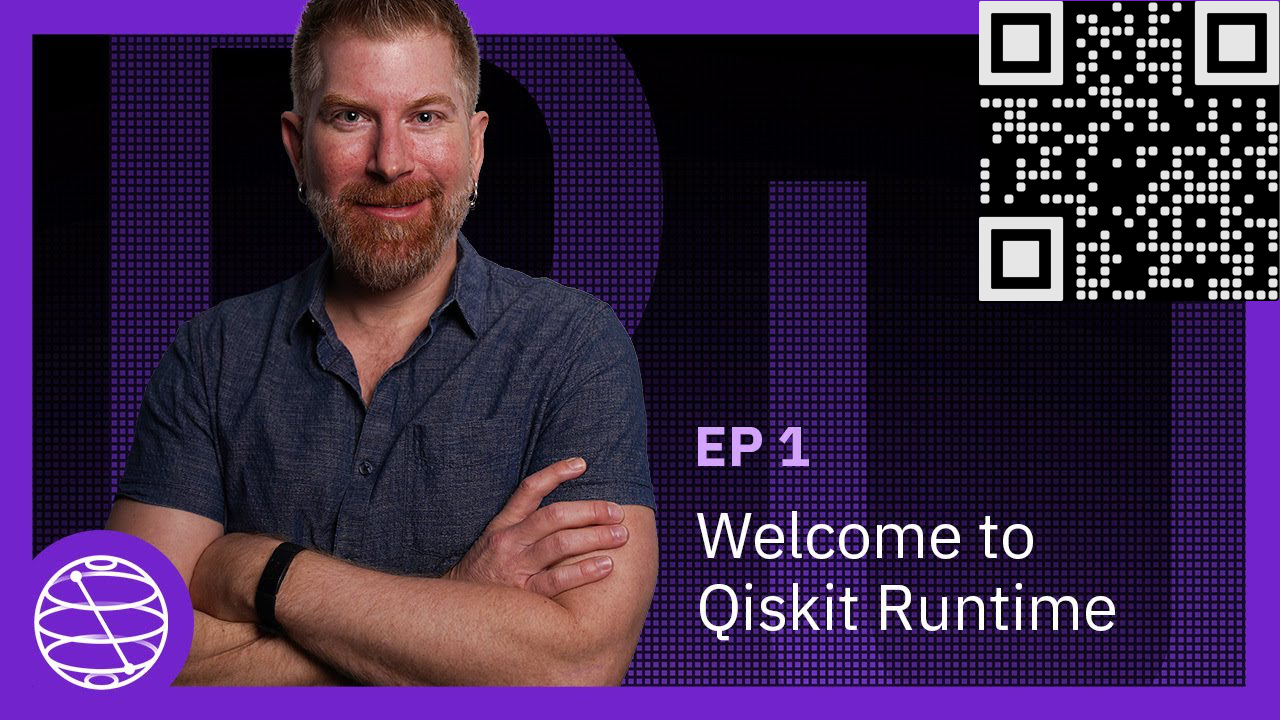
## with Nick Brønn
## IBM TechXchange 2023, MGM Grand, Las Vegas
## [https://ibm.biz/runtime-tutorial](https://ibm.biz/runtime-tutorial)

#### Abstract

Immerse yourself into the fascinating world of quantum computing with Qiskit Runtime, a unique service enabling users to optimize workloads and execute them efficiently on quantum systems. Explore the modular abstraction within its programming model, featuring Primitives as entry points to the service. These Primitives, namely Sampler and Estimator, allow users to calculate quantum outcomes and observables, all while simplifying complexities like error suppression. Learn how executing these primitives within a Runtime Session can lead to substantial performance improvements. This session will offer an in-depth understanding of these key components, taking your quantum computing knowledge to the next level.

[Youtube series](https://www.youtube.com/watch?v=CtZmczjjhik&list=PLOFEBzvs-VvqAC8DnVoLOzg2bKE4C7ARM)

# Overview

## - Runtime Big Picture
## - Warm Up: Sampler and Estimator
## - Use Case: Ground state energy of $H_2$
## - Mitigating errors on noisy quantum hardware

Let's first give the big picture of Qiskit Runtime, before diving into details in later in the series. 

Qiskit Runtime is a quantum computing service and programming model that allows users to optimize workloads and efficiently execute them on quantum systems at scale. The programming model extends the existing interface in Qiskit with a set of new primitives.

Runtime allows modular abstraction for programming algorithms by introducing new concepts called Primitives that form the entry point to the Qiskit Runtime service. After opening a Runtime Session, there are several features that allow fast and efficient quantum computation including
- Queue priority: once a Session is open, subsequent jobs sent to the device will be grouped -- removing the queueing delays
- Callbacks: access to interim data during a Session 

This level of abstraction is designed to make quantum computing useful without having to worry about all the details...

As an overview: if you are familiar with Qiskit you start with a quantum circuit just as before. After opening a Runtime session your first primitive call puts you in the queue, and when it's your turn the primitive sends the appropriate circuits to the Execution Kernel, which then runs the job on quantum hardware. The results are then passed back to the Qiskit program, where we can use our interim results to inform our search space exploration.

Note that subsequent session jobs have priority in the queue, thereby reducing latency and increasing efficiency. 

# Runtime Session Execution Flow
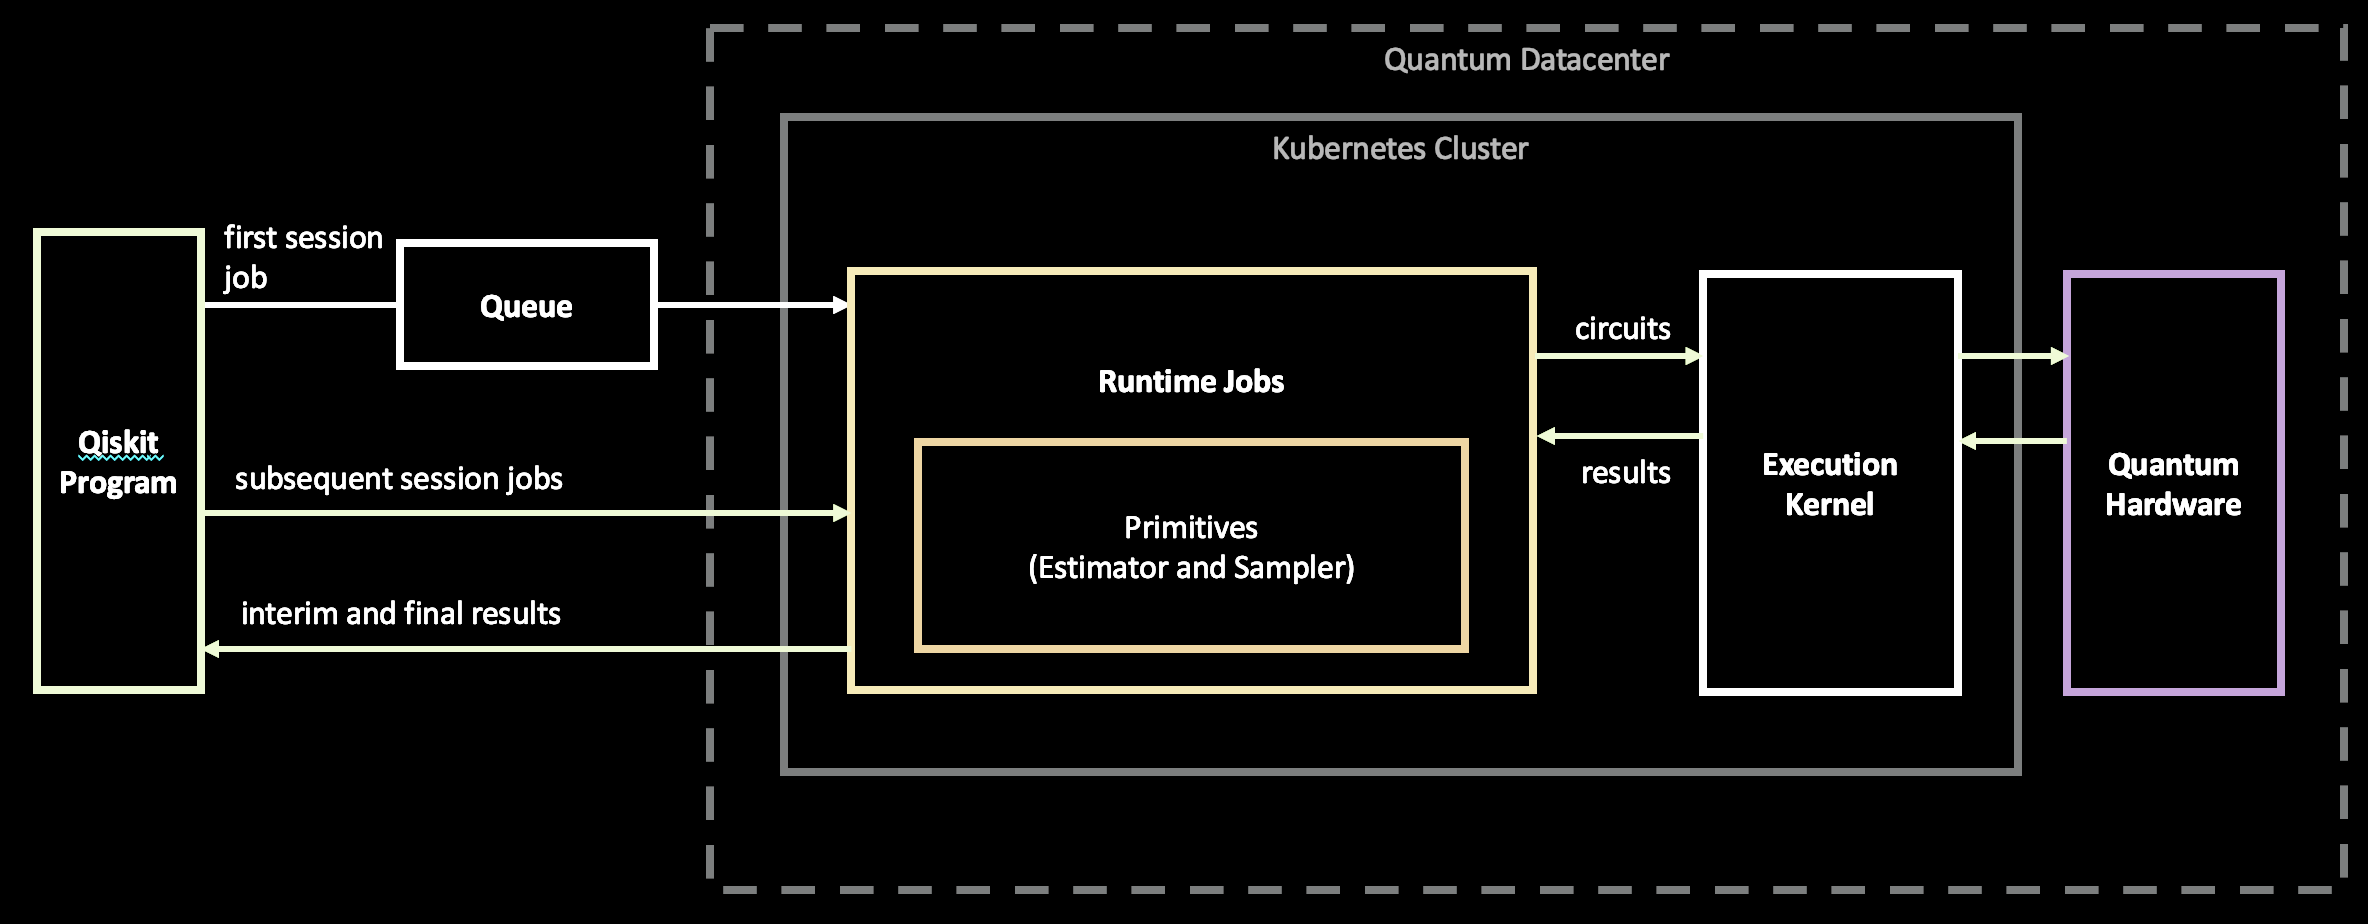

## Quick Primitives Overview

- `Sampler`: Yields (quasi-)probabilities of measurement outcomes
- `Estimator`: Yields expectation values of an observable

[Variational Algorithm Design](https://learning.quantum-computing.ibm.com/course/variational-algorithm-design) course covers primitives in greater detail

The two primitives currently available are called the `Sampler` and `Estimator`. We have a [Variational Algorithm Design](https://learning.quantum-computing.ibm.com) course where these primitives are covered in greater detail. You'll learn how to use them to design variational algorithms and can earn a badge at the end. But here's a simple overview of the `Sampler` and `Estimator`

The `Sampler` is closest to what you are used to from Qiskit, but instead of counts representing the number of times a resulting bit-string is obtained, the quasi-probabilities of measuring the bit-string are reported. This generalization allows for the possibility of applying error mitigation to your results.

The `Estimator` allows one to efficiently construct the expectation value of an observable. As a refresher, an expectaion value is the weighted average of state measurements. Observables might be the energy of a molecular wavefunction prepared by a quantum circuit or the value of a cost function. We know from the Heisenberg uncertainty principle that some measurements are incompatible with each other. The Estimator will efficiently group compatible measurements in your desired observable to reduce the needed preparations and measurements. Also, sophisticated types of error mitigation can be applied to observables (with the `Estimator`).

# Warm Up

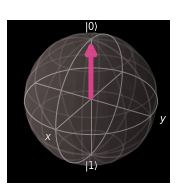

In [1]:
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
import matplotlib.pyplot as plt
plt.style.use('dark_background')

qc_0 = QuantumCircuit(1)
bl_0 = plot_bloch_multivector(Statevector(qc_0), figsize=(3, 3))

# display qubit in ground |0> state
display(bl_0)

## Prepare $|1\rangle$

In [2]:
# create excited |1> state
qc_1 = QuantumCircuit(1)
qc_1.x(0)
c_1 = qc_1.draw('mpl')

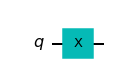

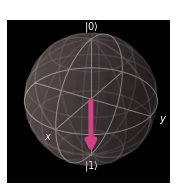

In [3]:
bl_1 = plot_bloch_multivector(Statevector(qc_1), figsize=(3, 3))

display(c_1, bl_1)

## Prepare Superposition

In [4]:
# create superposition |+> state
qc_plus = QuantumCircuit(1)
qc_plus.h(0)
c_p = qc_plus.draw('mpl')

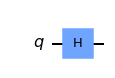

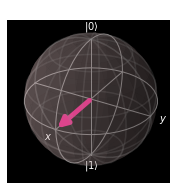

In [5]:
bl_p = plot_bloch_multivector(Statevector(qc_plus), figsize=(3, 3))
display(c_p, bl_p)

Create circuits that put the qubit in the excited $|1\rangle$ and superposition $|+\rangle$ states, respectivly, and measure them in different bases. This is done first with the `Sampler` primitive (which is most similar to the `backend.run()` used in the previous lab), and then with the `Estimator` primitive to show how measurement is abstracted in that we do not need to worry about rotating the qubit into the appropriate measurement basis. The primitives will be executed withing the `Session` context which allows efficiency to optimize workloads.

### Sampler Primitive

First use the `Sampler` to measure qubits in the $Z$-basis (the physical basis in which qubits are measured). The `Sampler` will count the number of outcomes of the $|0\rangle$ state and $|1\rangle$ state, normalized by the number of shots (experiments performed). The `Sampler` also offers the ability to easily perform error mitigation (which is covered in Lab 5), which modifies this calculation, and hence the outcomes are refered to as *quasi-probabilities*.

Measurements must be present in the circuit when using the `Sampler` primitive. Then the `Session` context is opened, the `Sampler` is instantiated, and `sampler.run()` is used to send the circuits to the backend, similar to the `backend.run()` syntax you may already be familiar with.

# Sampler Primitive

In [6]:
from qiskit.primitives import Sampler

qc_1.measure_all()
qc_plus.measure_all()

sampler = Sampler()
job_1 = sampler.run(qc_1)
job_plus = sampler.run(qc_plus)

In [7]:
job_1.result().quasi_dists

[{1: 1.0}]

In [8]:
job_plus.result().quasi_dists

[{0: 0.4999999999999999, 1: 0.4999999999999999}]

# Sampler Primitive

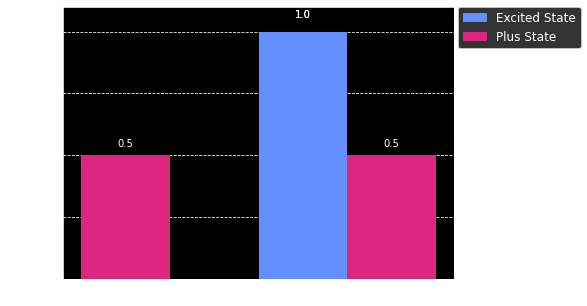

In [9]:
from qiskit.visualization import plot_histogram

legend = ["Excited State", "Plus State"] 
plot_histogram([job_1.result().quasi_dists[0], job_plus.result().quasi_dists[0]], legend=legend)

The result for the excited state is always $|1\rangle$ wheres it is roughly half $|0\rangle$ and half $|1\rangle$ for the plus superposition state. This is because the $|0\rangle$ and $|1\rangle$ states are *eigenstates* of the $Z$ operator (with $+1$ and $-1$ eigenvalues, respectively).

Let's switch and measure in the $X$ basis. Using the `Sampler` we must rotate the qubit from the $X$-basis to the $Z$-basis for measurement (because that is the only basis we can actually perform measurement in).

## Now Measure in $X$-basis

In [10]:
qc_1.remove_final_measurements()
qc_plus.remove_final_measurements()

# rotate into the X-basis
qc_1.h(0)
qc_plus.h(0)

qc_1.measure_all()
qc_plus.measure_all()

In [11]:
sampler = Sampler()
job_1 = sampler.run(qc_1)
job_plus = sampler.run(qc_plus)

## $X$-basis Measurement

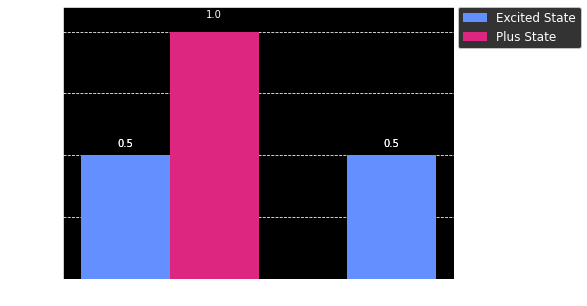

In [12]:
plot_histogram([job_1.result().quasi_dists[0], job_plus.result().quasi_dists[0]], legend=legend)

Now we see the opposite: the plus superposition always give the 1 result, hence an eigenstate of the $X$ operator, whereas the excited $|1\rangle$ yields a roughtly fifty-fifty split. The $|+\rangle$ and $|-\rangle$ states are eigenstates of the $X$ operator, with eigenvalues $+1$ and $-1$, respectively. This is good to remember when considering how the `Estimator` works in the next subsection. 

### Estimator Primitive

The Qiskit Runtime Primitives allow us to abstract measurement into the `Estimator` primitive, where it is specified as an *observable*. In particular, we can construct the same circuits, the excited $|1\rangle$ and superposition $|+\rangle$ as before. However, in the case of the `Estimator`, we *do not* add measurements to the circuit. Instead, specify a list of observables which take the form of Pauli strings. In our case for a measurement of a single qubit, we specify `'Z'` for the $Z$-basis and `'X'` for the $X$-basis.

# Estimator Primitive

In [13]:
from qiskit.quantum_info import SparsePauliOp

qc2_1 = QuantumCircuit(1)
qc2_1.x(0)

qc2_plus = QuantumCircuit(1)
qc2_plus.h(0)

obsvs = list(SparsePauliOp(['Z', 'X']))

In [14]:
from qiskit.primitives import Estimator

estimator = Estimator()
job2_1 = estimator.run([qc2_1]*len(obsvs), observables=obsvs)
job2_plus = estimator.run([qc2_plus]*len(obsvs), observables=obsvs)

# Estimator Abstracts Measurement

In [15]:
job2_1.result()

EstimatorResult(values=array([-1.,  0.]), metadata=[{}, {}])

In [16]:
job2_plus.result()

EstimatorResult(values=array([0., 1.]), metadata=[{}, {}])

In [17]:
print(f'    |  <Z>  |  <X> ')
print(f'----|------------------')
print(f'|1> | {job2_1.result().values[0]:.1f}  |  {job2_1.result().values[1]:.1f}')
print(f'|+> |  {job2_plus.result().values[0]:.1f}  |  {job2_plus.result().values[1]:.1f}')

    |  <Z>  |  <X> 
----|------------------
|1> | -1.0  |  0.0
|+> |  0.0  |  1.0


Just as before, we see the $|1\rangle$ state expectation in the $Z$-basis is $-1$ (corresponding to its eigenvalue) and around zero in the $X$-basis (average over $+1$ and $-1$ eigenvalues), and vice-versa for the $|+\rangle$ state (although its eigenvalue of the $X$ operators is $+1$).

# Variational Quantum Eigensolver

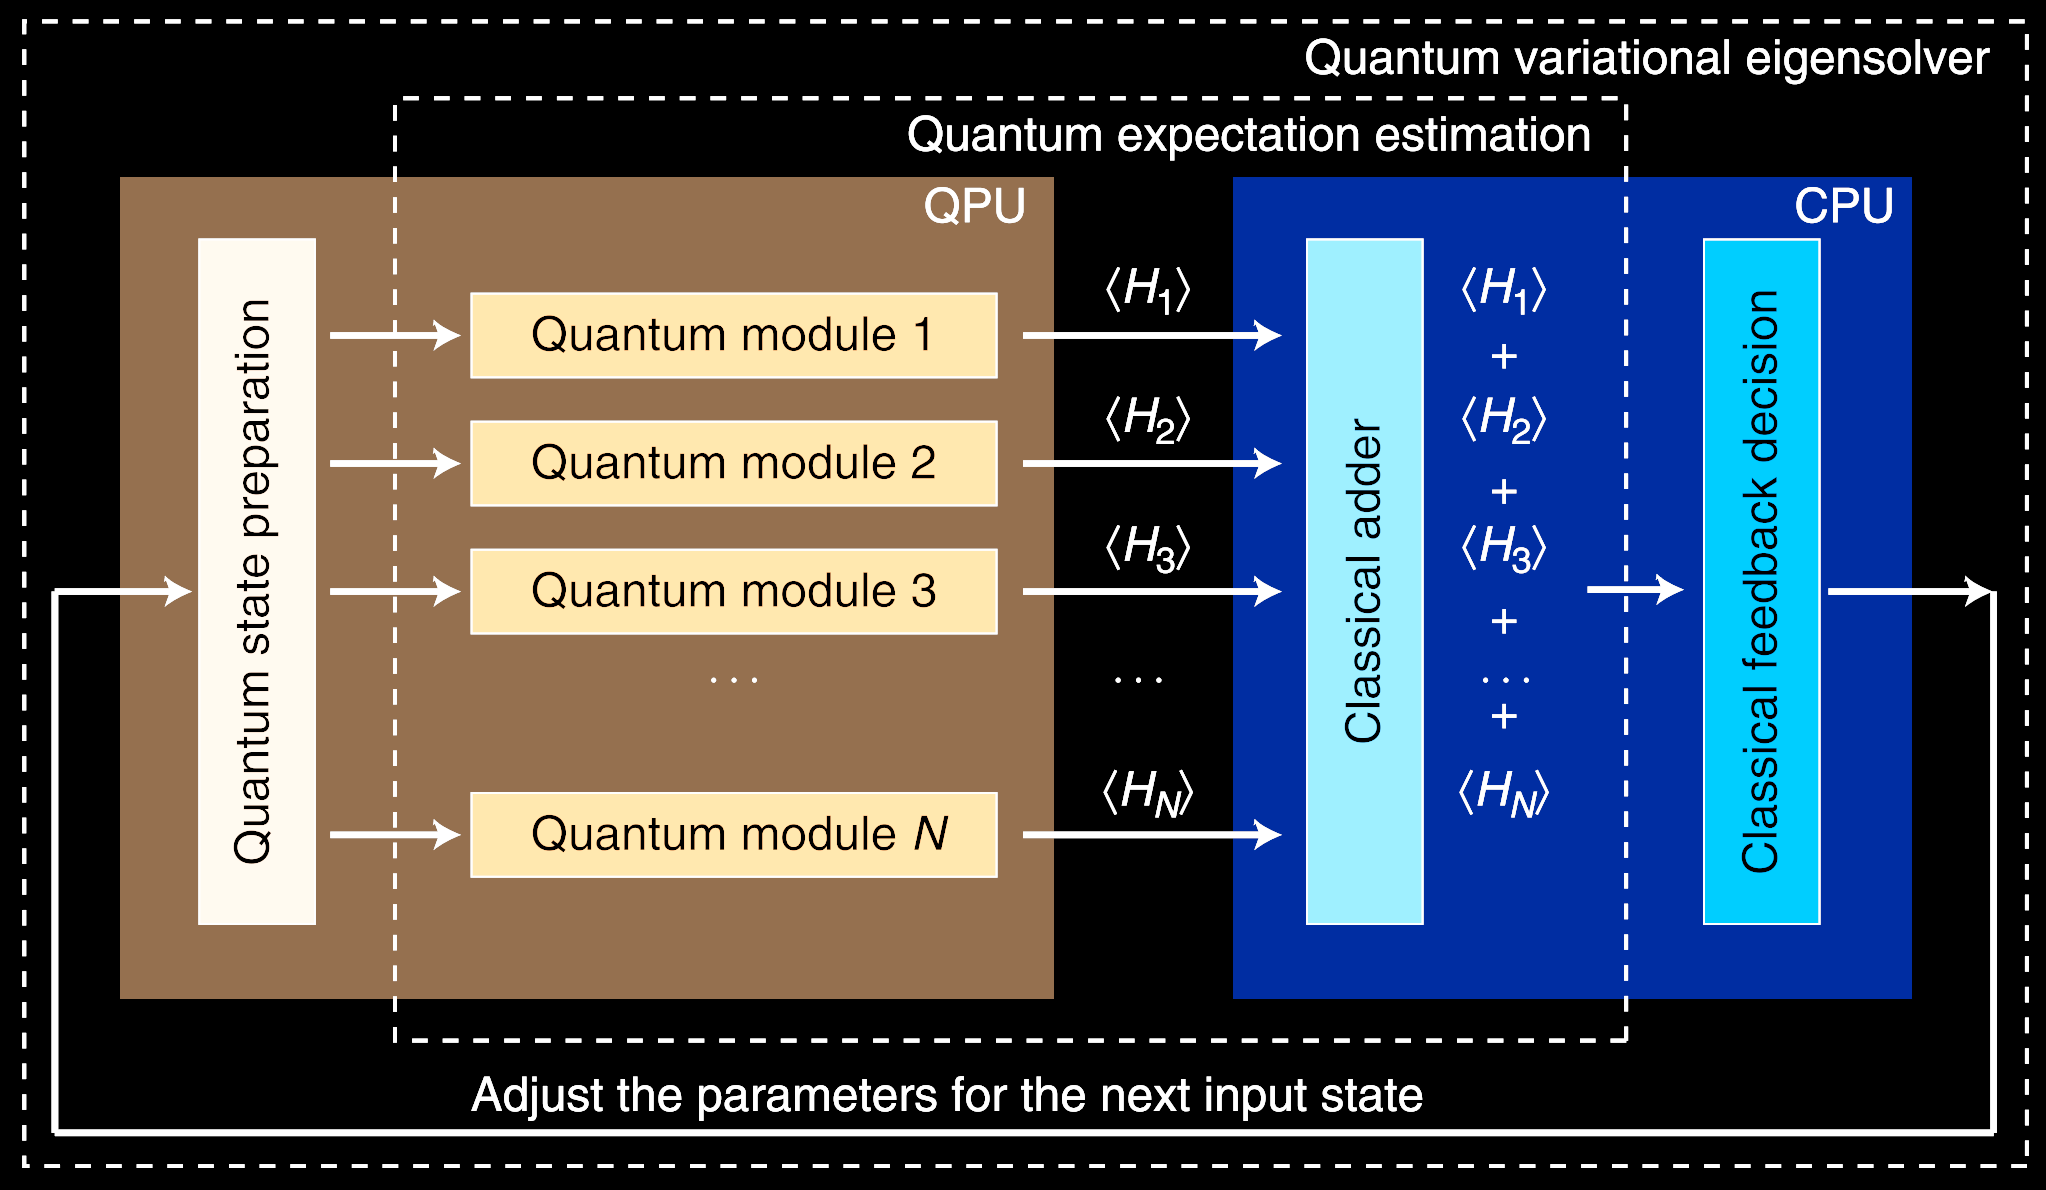
[A Peruzzo, *et al*, "A variational eigenvalue solver on a photonic quantum processor," *Nature Communications* **5**, 4213 (2015)]

The Variational Quantum Eigensolver, or *VQE*, works by preparing a quantum state on a quantum computer, here called quantum processing unit. In physics and chemistry, the Hamiltonian describes the energy of a quantum system such as a molecule, and is in general a sum of observables that can be measured on a quantum computer. By estimating these observables and summing them by the approriate weights which yields the energy, a classical optimizer then attempts to prepare states with less energy (for example using gradient descent methods). Because of the variational principle of quantum mechanics, the measured energy will always be at least that of the ground state. These methods are similar to those in machine learning and optimization, and can be extended to higher energy levels of molecules as well.

In [18]:
# use the OpenFermion package to calculate molecular properties
# and convert them to a Hamiltonian that can be computed on a quantum computer
from openfermion import MolecularData, jordan_wigner

# helper function to convert this Hamiltonian from OpenFermion to Qiskit framework
from helper import convert_openfermion_to_qiskit

import numpy as np

In [19]:
multiplicity = 1
basis = 'sto-3g'
charge = 0
sparse_pauli_list = []
bond_lengths = np.arange(0.3, 2.5, 0.1)
for bond_length in bond_lengths:
    # Setup the molecule at the bond length and load data
    geometry = [['H', [0, 0, 0]], ['H', [0, 0, bond_length]]]
    molecule = MolecularData(geometry, basis, multiplicity, 
        charge, description=f'{bond_length:.1f}')
    molecule.load()
    # Get the Hamiltonian in an active space.
    active_space_start = 0
    active_space_stop = 2
    hamiltonian = molecule.get_molecular_hamiltonian(
        occupied_indices=range(active_space_start),
        active_indices=range(active_space_start, active_space_stop)
    )
    # Get QubitOperator and convert to Qiskit SparsePauliOps
    molecule_pauli = jordan_wigner(hamiltonian)
    qiskit_operator = convert_openfermion_to_qiskit(molecule_pauli, molecule.n_qubits)
    sparse_pauli_list.append(qiskit_operator)

# Exact Numerical Calculation

In [20]:
min_eigens = [min(np.linalg.eigvalsh(sparse_pauli.to_matrix())) 
    for sparse_pauli in sparse_pauli_list]

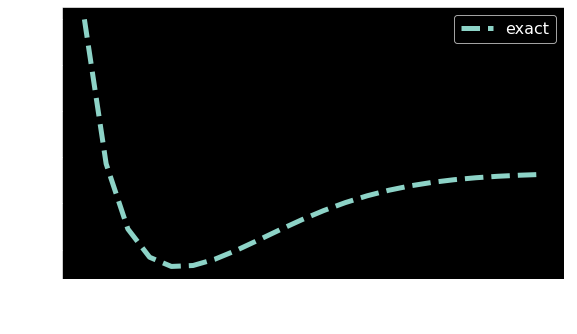

In [21]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(bond_lengths, min_eigens, ls='--', lw=5, label=f'exact')
ax.set_xlabel('bond length ($\AA$)', fontsize=20)
ax.set_ylabel('energy (hartree)', fontsize=20)
ax.legend(loc=1, fontsize=16)
_ = ax.plot()

# Run on a local simulator

In [22]:
# EfficientSU2 is an ansatz, a parametereized guess of the structure of the wavefunction
from qiskit.circuit.library import EfficientSU2

# the Estimator from Terra is the base class
from qiskit.primitives import Estimator 

estimator = Estimator()
ansatz = EfficientSU2(4, reps=5)

Let's take a look at our ansatz: we see it consists of three layers of parameterized $Y$ and $Z$ rotations with CNOTs and the entanglers.

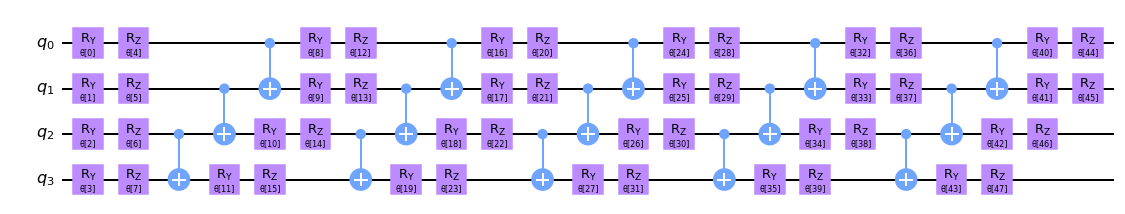

In [23]:
ansatz.decompose().draw('mpl', fold=-1)

Setup cost function first -- this is what we'll use to calculate our energy

## Cost Function for Optimizer

In [24]:
def cost_func(params, ansatz, operator, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    energy = estimator.run(ansatz, operator, parameter_values=params).result().values[0]
    return energy

In [25]:
from scipy.optimize import minimize

num_params = ansatz.num_parameters
rng = np.random.default_rng(seed=12345)
x0 = rng.uniform(-np.pi, np.pi, num_params)

results = []
for index, operator in enumerate(sparse_pauli_list):
    res = minimize(cost_func, x0, args=(ansatz, operator, estimator), method="cobyla")
    print(f"""Bond Length {bond_lengths[index]:.1f}Å: {res.fun}""")
    results.append(res.fun)

Bond Length 0.3Å: -0.5990631046184793
Bond Length 0.4Å: -0.91276466565812
Bond Length 0.5Å: -1.0532445985659933
Bond Length 0.6Å: -1.1145612316002376
Bond Length 0.7Å: -1.1334719330033027
Bond Length 0.8Å: -1.1316572137353955
Bond Length 0.9Å: -1.1196354657752632
Bond Length 1.0Å: -1.0972181966375552
Bond Length 1.1Å: -1.0771472924870051
Bond Length 1.2Å: -1.055497116548557
Bond Length 1.3Å: -1.0336089268181607
Bond Length 1.4Å: -1.0121096150972027
Bond Length 1.5Å: -0.9975427130423365
Bond Length 1.6Å: -0.9783047978323678
Bond Length 1.7Å: -0.9685285780136297
Bond Length 1.8Å: -0.9597241754772681
Bond Length 1.9Å: -0.9508010616121384
Bond Length 2.0Å: -0.9464973398715593
Bond Length 2.1Å: -0.9423575080747291
Bond Length 2.2Å: -0.9394717611100407
Bond Length 2.3Å: -0.9353291941726938
Bond Length 2.4Å: -0.9342922280352235


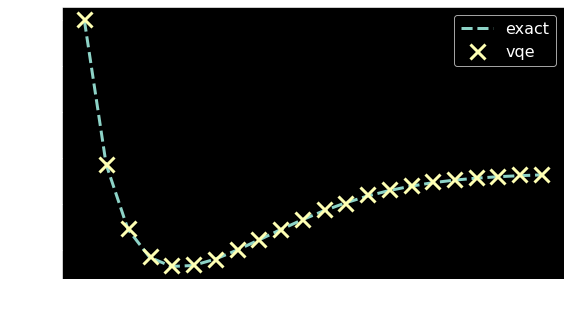

In [26]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(bond_lengths, min_eigens, ls='--', lw=3, label=f'exact')
ax.plot(bond_lengths, results, ls=' ', marker='x', ms=15, mew=3, label=f'vqe')
ax.set_xlabel('bond length ($\AA$)', fontsize=20)
ax.set_ylabel('energy (hartree)', fontsize=20)
ax.legend(loc=1, fontsize=16)
_ = ax.plot()

## To Run on Real HW

To run on real hearware requires a Qiskit Runtime service instance. 

- Follow the instructions in the [Getting started guide](https://docs.quantum-computing.ibm.com/start) to set one up (if you haven't done so already) 
   - I made a [video](https://www.youtube.com/watch?app=desktop&v=b9mdMye-iVk) for that as well
   
- Import the `Sampler` and `Estimator` primitives from `qiskit_ibm_runtime` instead
- Also import `QiskitRuntimeService` and `Session`, which form the interface between Qiskit and Qiskit IBM Runtime
- The below examples can be run on real systems!
   - additional options can be specified in the `Sampler` and `Estimator` with the `Options` class
   
#### References:
- See this [how-to](https://docs.quantum-computing.ibm.com/run/run-sessions) for using Primitives with Runtime Sessions.
- [IBM Runtime docs](https://docs.quantum-computing.ibm.com)

## Understanding Sessions

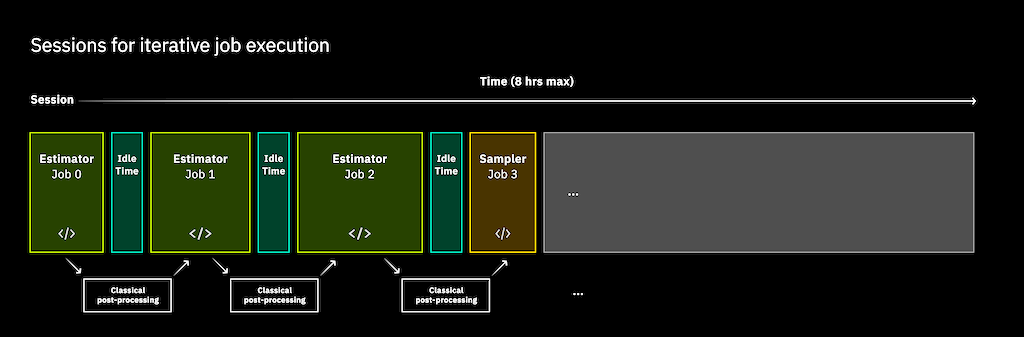

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator

# Add your token below
service = QiskitRuntimeService(channel='ibm_quantum')

# Select the backend with the fewest number of jobs in the queue
backend = service.least_busy(simulator=False, operational=True)
backend.name

In [ ]:
# Open a session
session = Session(service=service, backend=backend)

In [ ]:
# Setup estimator with error mitigation and suppresion
from qiskit_ibm_runtime import Options

options = Options(resilience_level=2, optimization_level=3)
estimator = Estimator(session=session, options=options)

In [ ]:
from scipy.optimize import minimize
import numpy as np

num_params = ansatz.num_parameters
x0 = 2 * np.pi * np.random.random(num_params)

hardware_results = []

for index, operator in enumerate(sparse_pauli_list):
    res = minimize(cost_func, x0, args=(ansatz, operator, estimator), method="cobyla")
    print(f"""Bond Length {bond_lengths[index]:.1f}Å: {res.fun}""")
    hardware_results.append(res.fun)

In [ ]:
# Close session
session.close()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(bond_lengths, min_eigens, ls='--', lw=2, label=f'exact')
ax.plot(bond_lengths, results, ls=' ', marker='x', label=f'vqe')
ax.plot(bond_lengths, results, ls=' ', marker='o', label=f'vqe-hw')
ax.set_xlabel('bond length ($\AA$)', fontsize=14)
ax.set_ylabel('energy (hartree)', fontsize=14)
ax.legend(loc=1)
_ = ax.plot()

In [27]:
!conda list qiskit

# packages in environment at /opt/anaconda3/envs/qiskit-stable:
#
# Name                    Version                   Build  Channel
qiskit                    0.44.1                   pypi_0    pypi
qiskit-aer                0.12.0                   pypi_0    pypi
qiskit-ibm-provider       0.7.0                    pypi_0    pypi
qiskit-ibm-runtime        0.12.0                   pypi_0    pypi
qiskit-ibmq-provider      0.20.2                   pypi_0    pypi
qiskit-qasm3-import       0.1.0                    pypi_0    pypi
qiskit-terra              0.25.1                   pypi_0    pypi


# Thanks for your Attention!